## (GSE48213): Identifying gene expression patterns associated with different breast cancer subtypes

The dataset includes both treated (estrogen) and control conditions. 
We use Adaptive CCA to identify differences in gene expression patterns between these conditions over time.

The time points (1, 2, 4, 8, 12 hours) are not equally spaced, which is common in biological experiments. 
- Adaptive CCA should handle such non-linear time progressions 

In [69]:
import os
import pandas as pd
import numpy as np

file_path = os.path.join(os.getcwd(), "..", "data", "GSE48213")

In [70]:
os.getcwd()

'c:\\Users\\anaca\\Documents\\quinto.curso\\mitfg\\cca_manifolds\\ss24_CCA_Reduced_Rank\\src'

Dataset overview:

- 56 breast cancer cell lines were profiled
- The data represents gene expression levels in these cell lines
- Each cell line is in an unperturbed, baseline state


In current file: 

1. Column 1 (EnsEMBL_Gene_ID): unique identifier for each gene from the Ensembl database
2. Column 2 (e.g., MDAMB453): expression value for each gene in the specific cell line.

These are normalized read counts or FPKM/TPM values (Fragments/Transcripts Per Kilobase Million).
Higher values indicate higher expression of the gene in that cell line, zero values indicate that the gene is not expressed (or expression is below detection threshold)


In [71]:
from utils.utils import load_data
load_data(file_path, os.getcwd())

Index set to EnsEMBL_Gene_ID
Combined data has been saved to c:\Users\anaca\Documents\quinto.curso\mitfg\cca_manifolds\ss24_CCA_Reduced_Rank\src\combined_data.txt


,GSM1172844_184A1,GSM1172845_184B5,GSM1172846_21MT1,GSM1172847_21MT2,GSM1172848_21NT,GSM1172849_21PT,GSM1172850_600MPE,GSM1172851_AU565,GSM1172853_BT474,GSM1172854_BT483,...,GSM1172902_SUM229PE,GSM1172903_SUM52PE,GSM1172904_T47D,GSM1172905_T47DKBluc,GSM1172906_UACC812,GSM1172907_UACC893,GSM1172908_ZR751,GSM1172909_ZR7530,GSM1172910_ZR75B,GSM1384316_MDAMB453
EnsEMBL_Gene_ID,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,95.212548,95.698676,19.994674,65.686376,44.057746,34.317565,178.158832,13.460144,37.879666,69.092581,...,39.425097,129.418091,82.748694,73.387310,26.579280,50.676579,31.812999,121.459918,2.293898,2.025956
ENSG00000001167,89.512619,94.154375,245.433541,216.487072,286.092419,289.298295,125.193255,68.907655,167.815672,152.752421,...,111.108369,102.457186,61.650437,106.114416,138.140311,106.342032,68.458022,73.910964,61.625519,136.161392
ENSG00000005471,0.000000,0.172734,0.231762,0.099938,0.000000,0.000000,0.757785,2.976117,1.210384,1.670807,...,0.000000,0.784523,1.261100,0.536226,0.440649,0.066213,0.548865,0.611036,0.556531,0.087010
ENSG00000066629,24.701397,7.633869,5.842132,6.773438,5.149179,7.432176,29.604076,15.084108,30.669290,135.100074,...,0.604542,90.533172,74.463574,34.619613,79.187879,0.058835,25.493800,25.917323,32.528112,0.000000
ENSG00000154258,0.000000,2.683498,0.000000,0.031877,0.000000,0.000000,0.652424,0.000000,0.065451,0.000000,...,0.096449,0.199749,0.000000,0.000000,0.040907,0.021120,0.000000,0.033571,0.177808,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000154229,50.153014,6.307886,73.198238,45.283423,91.826948,94.667006,4.835407,51.196873,18.660523,1.271292,...,21.040694,14.643540,12.301795,3.499372,14.153042,16.090697,6.794076,12.442838,10.691891,2.490993
ENSG00000154237,51.372615,19.782605,39.113584,50.052251,28.074873,30.620917,4.591209,3.121563,1.780330,5.195107,...,23.502861,5.566392,23.877050,11.215556,4.693441,10.134877,21.428970,41.384456,13.321714,3.255213
ENSG00000154240,14.735200,5.071096,1.690885,0.521761,1.303221,0.930950,10.099978,0.222417,1.264567,0.846007,...,0.471525,10.237144,8.358125,2.931238,4.954351,0.447181,3.717654,2.425406,4.566561,0.000000


In [72]:
output_file = os.path.join(os.getcwd(), "combined_data.txt")
data = pd.read_csv(output_file, sep="\t")

In [73]:
data.head()

,EnsEMBL_Gene_ID,GSM1172844_184A1,GSM1172845_184B5,GSM1172846_21MT1,GSM1172847_21MT2,GSM1172848_21NT,GSM1172849_21PT,GSM1172850_600MPE,GSM1172851_AU565,GSM1172853_BT474,...,GSM1172902_SUM229PE,GSM1172903_SUM52PE,GSM1172904_T47D,GSM1172905_T47DKBluc,GSM1172906_UACC812,GSM1172907_UACC893,GSM1172908_ZR751,GSM1172909_ZR7530,GSM1172910_ZR75B,GSM1384316_MDAMB453
0,ENSG00000000003,95.212548,95.698676,19.994674,65.686376,44.057746,34.317565,178.158832,13.460144,37.879666,...,39.425097,129.418091,82.748694,73.387310,26.579280,50.676579,31.812999,121.459918,2.293898,2.025956
1,ENSG00000001167,89.512619,94.154375,245.433541,216.487072,286.092419,289.298295,125.193255,68.907655,167.815672,...,111.108369,102.457186,61.650437,106.114416,138.140311,106.342032,68.458022,73.910964,61.625519,136.161392
2,ENSG00000005471,0.000000,0.172734,0.231762,0.099938,0.000000,0.000000,0.757785,2.976117,1.210384,...,0.000000,0.784523,1.261100,0.536226,0.440649,0.066213,0.548865,0.611036,0.556531,0.087010
3,ENSG00000066629,24.701397,7.633869,5.842132,6.773438,5.149179,7.432176,29.604076,15.084108,30.669290,...,0.604542,90.533172,74.463574,34.619613,79.187879,0.058835,25.493800,25.917323,32.528112,0.000000
4,ENSG00000154258,0.000000,2.683498,0.000000,0.031877,0.000000,0.000000,0.652424,0.000000,0.065451,...,0.096449,0.199749,0.000000,0.000000,0.040907,0.021120,0.000000,0.033571,0.177808,0.000000


In [74]:
data.columns


Index(['EnsEMBL_Gene_ID', 'GSM1172844_184A1', 'GSM1172845_184B5',
       'GSM1172846_21MT1', 'GSM1172847_21MT2', 'GSM1172848_21NT',
       'GSM1172849_21PT', 'GSM1172850_600MPE', 'GSM1172851_AU565',
       'GSM1172853_BT474', 'GSM1172854_BT483', 'GSM1172855_BT549',
       'GSM1172856_CAMA1', 'GSM1172858_EFM192A', 'GSM1172859_EFM192B',
       'GSM1172860_EFM192C', 'GSM1172861_HCC1143', 'GSM1172863_HCC1395',
       'GSM1172864_HCC1419', 'GSM1172865_HCC1428', 'GSM1172867_HCC1569',
       'GSM1172868_HCC1599', 'GSM1172869_HCC1806', 'GSM1172870_HCC1937',
       'GSM1172871_HCC1954', 'GSM1172872_HCC202', 'GSM1172873_HCC2218',
       'GSM1172874_HCC3153', 'GSM1172875_HCC38', 'GSM1172876_HCC70',
       'GSM1172877_HS578T', 'GSM1172878_JIMT1', 'GSM1172879_LY2',
       'GSM1172881_MB157', 'GSM1172882_MCF10A', 'GSM1172883_MCF10F',
       'GSM1172884_MCF12A', 'GSM1172885_MCF7', 'GSM1172886_MDAMB134v1',
       'GSM1172888_MDAMB175VII', 'GSM1172889_MDAMB231', 'GSM1172890_MDAMB361',
       'GSM117289

#### Preprocessing: Log2 Transformation
Gene expression values vary too much across genes and cell lines, with some genes having very high expression values and others having very low ones (sometimes even zero). This creates a skewed distribution. A log2 transformation helps to normalize this range and make the data more comparable across genes and cell lines.
- without log transformation, highly expressed genes dominate the analysis, hiding patterns in the data for moderately or lowly expressed genes.

In [75]:
# ---------- PREPROCESSING ----------  #
from preprocessing import log2_transform, classify

log2_data = log2_transform(data)
# classify(log2_data)


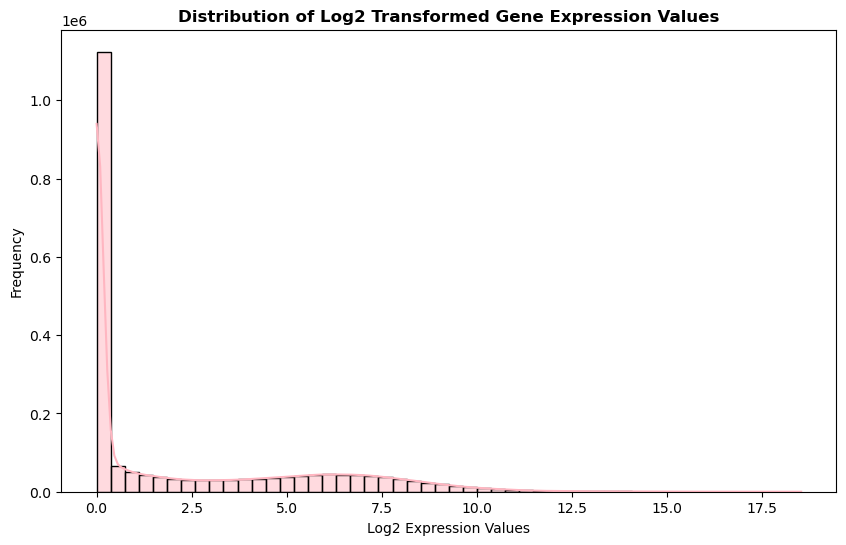

C:\Users\anaca\AppData\Local\Temp\ipykernel_33540\3616096287.py:27: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  ax = sns.boxplot(data=data, palette=colors)


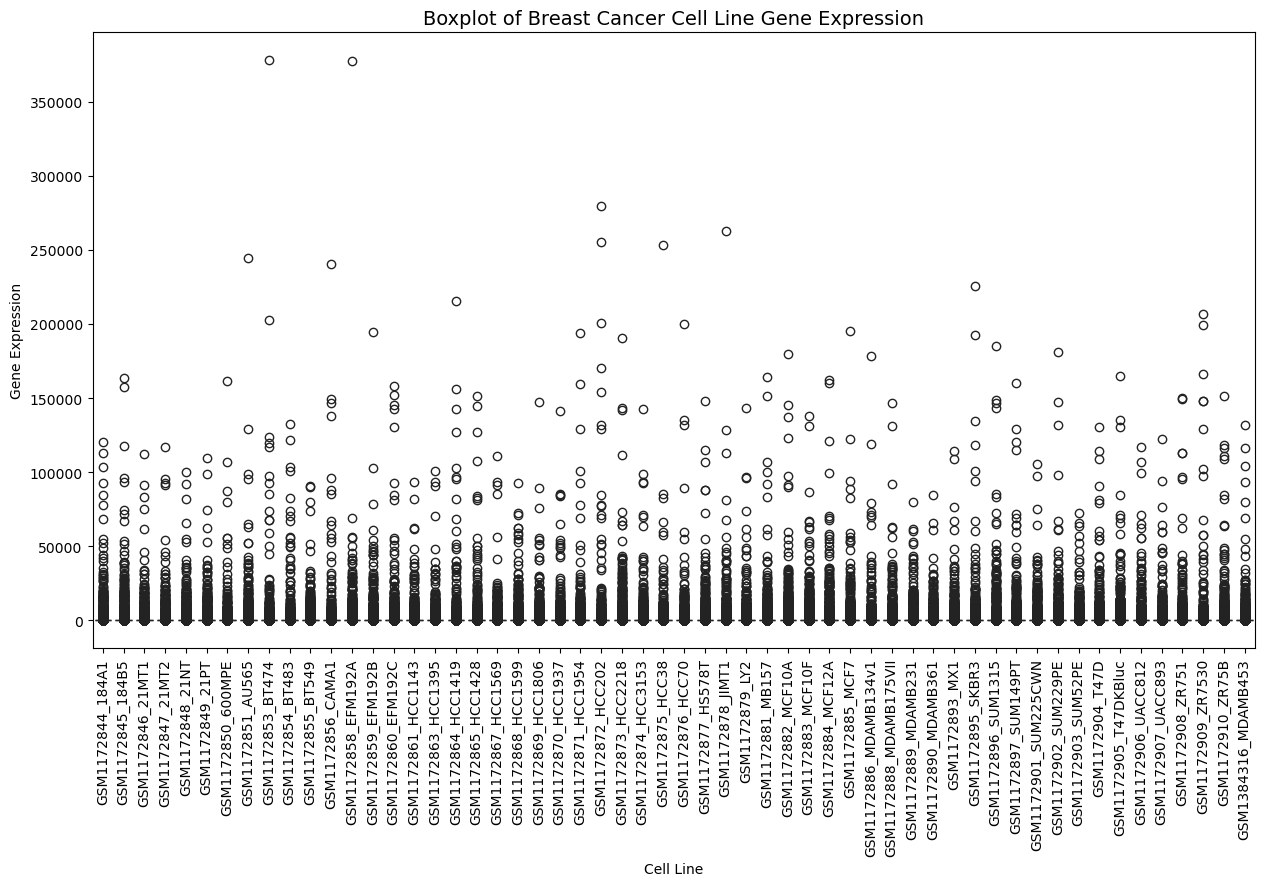

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_distribution(log2_transformed_data: pd.DataFrame):
    """
    Plots the distribution of log2 transformed gene expression data.
    
    Arguments:
    - log2_transformed_data: DataFrame with the log2 transformed gene expression values.
    """
    # Exclude the gene ID column
    expression_data = log2_transformed_data.iloc[:, 1:]
    
    # Histogram
    plt.figure(figsize=(10, 6))
    sns.histplot(expression_data.values.flatten(), bins=50, kde=True, color='lightpink')
    plt.title('Distribution of Log2 Transformed Gene Expression Values', fontweight='bold')
    plt.xlabel('Log2 Expression Values')
    plt.ylabel('Frequency')
    plt.show()

    # Boxplot
    cmap = plt.cm.Blues
    colors = cmap(np.linspace(0.3, 1, 56))  # Generating shades of blue
    
    plt.figure(figsize=(15, 8))
    ax = sns.boxplot(data=data, palette=colors)
    
    plt.title("Boxplot of Breast Cancer Cell Line Gene Expression", fontsize=14)
    plt.xticks(rotation=90)
    plt.xlabel("Cell Line")
    plt.ylabel("Gene Expression")
    plt.show()

plot_distribution(log2_data)


In [77]:
expression_data = pd.read_csv('cell_line_subtypes.csv', index_col=0)  # Genes x Cell lines
# select rows for which column subtype is not "Unclsasified"
subtypes = expression_data['Subtype']
subtypes = subtypes[subtypes != 'Unclassified']
expression_data = expression_data.loc[subtypes.index]
print(expression_data)


                     Subtype
GSM1172908_ZR751   Luminal A
GSM1172909_ZR7530  Luminal A
GSM1172910_ZR75B   Luminal A


Of all data employed, no enough cell lines can be classified, leading to poor data information.

In [78]:
import gseapy as gp
import mygene

def classify_genes_in_pathways():
    """ 
    Find which genes are in which KEGG pathways.
    """
    data = pd.read_csv('combined_data.txt', sep='\t', index_col=0)
    genes = data.index.tolist()

    # Convert Ensembl IDs to gene symbols
    mg = mygene.MyGeneInfo()
    gene_info = mg.querymany(genes, scopes='ensembl.gene', fields='symbol', species='human')
    ensembl_to_symbol = {gene['query']: gene.get('symbol', '') for gene in gene_info if 'symbol' in gene} # create a dictionary of Ensembl IDs to gene symbols

    # Load KEGG pathway gene sets
    kegg_gene_sets = gp.get_library('KEGG_2021_Human')
    gene_pathway_map = {}

    for pathway, pathway_genes in kegg_gene_sets.items():
        # Find genes that are both in data and in the pathway
        common_genes = set(ensembl_to_symbol.values()).intersection(pathway_genes)
        
        # If there are common genes, add them to the gene_pathway_map
        for gene_symbol in common_genes:
            ensembl_ids = [ensembl for ensembl, symbol in ensembl_to_symbol.items() if symbol == gene_symbol]
            for ensembl_id in ensembl_ids:
                if ensembl_id not in gene_pathway_map:
                    gene_pathway_map[ensembl_id] = []
                gene_pathway_map[ensembl_id].append(pathway)

    # Create a DataFrame from the gene_pathway_map
    result_df = pd.DataFrame.from_dict(gene_pathway_map, orient='index')
    result_df.columns = [f'Pathway_{i+1}' for i in range(result_df.shape[1])]

    result_df.to_csv('gene_pathway_mappings.csv')
    
    total_genes = len(genes)
    mapped_genes = len(gene_pathway_map)
    print(f"Total genes in your data: {total_genes}")
    print(f"Genes mapped to KEGG pathways: {mapped_genes}")
    print(f"Percentage of genes mapped: {mapped_genes/total_genes*100:.2f}%")

    # Print the first few rows of the result
    print("\nFirst few gene-pathway mappings:")
    print(result_df.head())


In [79]:
classify_genes_in_pathways()

INFO:biothings.client:querying 1-1000...
INFO:biothings.client:done.
INFO:biothings.client:querying 1001-2000...
INFO:biothings.client:done.
INFO:biothings.client:querying 2001-3000...
INFO:biothings.client:done.
INFO:biothings.client:querying 3001-4000...
INFO:biothings.client:done.
INFO:biothings.client:querying 4001-5000...
INFO:biothings.client:done.
INFO:biothings.client:querying 5001-6000...
INFO:biothings.client:done.
INFO:biothings.client:querying 6001-7000...
INFO:biothings.client:done.
INFO:biothings.client:querying 7001-8000...
INFO:biothings.client:done.
INFO:biothings.client:querying 8001-9000...
INFO:biothings.client:done.
INFO:biothings.client:querying 9001-10000...
INFO:biothings.client:done.
INFO:biothings.client:querying 10001-11000...
INFO:biothings.client:done.
INFO:biothings.client:querying 11001-12000...
INFO:biothings.client:done.
INFO:biothings.client:querying 12001-13000...
INFO:biothings.client:done.
INFO:biothings.client:querying 13001-14000...
INFO:biothings

Total genes in your data: 36953
Genes mapped to KEGG pathways: 7511
Percentage of genes mapped: 20.33%

First few gene-pathway mappings:
                        Pathway_1       Pathway_2 Pathway_3 Pathway_4  \
ENSG00000064687  ABC transporters            None      None      None   
ENSG00000140798  ABC transporters            None      None      None   
ENSG00000150967  ABC transporters        Lysosome      None      None   
ENSG00000108846  ABC transporters  Bile secretion      None      None   
ENSG00000154265  ABC transporters            None      None      None   

                Pathway_5 Pathway_6 Pathway_7 Pathway_8 Pathway_9 Pathway_10  \
ENSG00000064687      None      None      None      None      None       None   
ENSG00000140798      None      None      None      None      None       None   
ENSG00000150967      None      None      None      None      None       None   
ENSG00000108846      None      None      None      None      None       None   
ENSG00000154265      Non

In [80]:
gene_expression = pd.read_csv('combined_data.txt', sep='\t', index_col=0)
gene_pathway_mappings = pd.read_csv('gene_pathway_mappings.csv', index_col=0)

In [81]:
from preprocessing import preprocessing
from sklearn.preprocessing import StandardScaler

X, Y = preprocessing(gene_expression, gene_pathway_mappings)

# Ensure X and Y are centered and scaled
scaler = StandardScaler()
X = scaler.fit_transform(X)
Y = scaler.fit_transform(Y)

# Set dimensions
n, p1 = X.shape
_, p2 = Y.shape
k = min(p1, p2, 10)  # number of canonical dimensions, adjust as needed

Missing values in gene expression data:
0
Shape of X (gene expression): (56, 36953)
Shape of Y (pathway activity): (56, 113)


In [82]:
# check if X or Y have Nan values
print(np.isnan(X).any())
print(np.isnan(Y).any())

False
False


In [87]:
from scipy.linalg import cholesky, polar

def cca_objective(X: np.ndarray, Y: np.ndarray, A: np.ndarray, B: np.ndarray) -> float:
    """ 
    Compute the objective function for CCA.

    Parameters:
    ----------
    X : np.ndarray
        The first dataset (genes with expressions).
    Y : np.ndarray
        The second dataset (pathways of the genes).
    A : np.ndarray
        The first projection matrix.
    B : np.ndarray
        The second projection matrix.
    """
    XA = X @ A
    YB = Y @ B
    corr = np.sum(XA * YB) / (n - 1)
    return -corr  # negative because we're maximizing

import numpy as np

def cca_gradient(X: np.ndarray, Y: np.ndarray, A: np.ndarray, B: np.ndarray) -> tuple:
    """ 
    Compute the gradient of the objective function for Canonical Correlation Analysis (CCA).
    """
    n_samples = X.shape[0]

    # Check matrix dimensions
    if X.shape[1] != A.shape[0] or Y.shape[1] != B.shape[0] or A.shape[1] != B.shape[1]:
        raise ValueError("Dimension mismatch: Please ensure X, Y, A, and B are compatible with shape requirements.")

    # Compute projections
    XA = X @ A  # Shape: (n_samples, k)
    YB = Y @ B  # Shape: (n_samples, k)
    
    # Compute gradients
    grad_A = -X.T @ YB / (n_samples - 1)
    grad_B = -Y.T @ XA / (n_samples - 1)

    return grad_A, grad_B

def cholesky_qr_retraction(X: np.ndarray, G: np.ndarray, xi: np.ndarray, epsilon=1e-6) -> np.ndarray:
    """ 
    Retract a point on the Stiefel manifold using the Cholesky QR retraction. Add regularization to avoid singular matrices.
    """
    Z = (X + xi).T @ G @ (X + xi)
    Z += epsilon * np.eye(Z.shape[0])  # Add regularization
    try:
        L = cholesky(Z, lower=True)
    except np.linalg.LinAlgError:
        # If Cholesky fails, fall back to Polar decomposition
        return polar_retraction(X, G, xi)
    retracted_point = (X + xi) @ np.linalg.inv(L.T)
    return retracted_point


def polar_retraction(X: np.ndarray, G: np.ndarray, xi: np.ndarray) -> np.ndarray:
    """ 
    Retract a point on the Stiefel manifold using the polar retraction.
    """
    Z = (X + xi).T @ G @ (X + xi)
    U, _ = polar(Z)
    retracted_point = (X + xi) @ np.linalg.inv(U.T)
    return retracted_point

In [123]:
import csv

def log_stability_data(filename, iteration, A, B, G_A, G_B):
    """
    Logs the L1 and Linf norms of matrices A, B, G_A, and G_B for each iteration.
    """
    with open(filename, mode='a', newline='') as file:
        writer = csv.writer(file)
        
        # Compute L1 and L∞ norms for each matrix
        A_l1 = np.linalg.norm(A, ord=1)
        A_inf = np.linalg.norm(A, ord=np.inf)
        B_l1 = np.linalg.norm(B, ord=1)
        B_inf = np.linalg.norm(B, ord=np.inf)
        G_A_l1 = np.linalg.norm(G_A, ord=1)
        G_A_inf = np.linalg.norm(G_A, ord=np.inf)
        G_B_l1 = np.linalg.norm(G_B, ord=1)
        G_B_inf = np.linalg.norm(G_B, ord=np.inf)
        
        # Write iteration and norms to the CSV
        writer.writerow([iteration] + 
                        [A_l1, A_inf] + 
                        [B_l1, B_inf] + 
                        [G_A_l1, G_A_inf] + 
                        [G_B_l1, G_B_inf])

def init_stability_log(filename: str, k: int):
    """
    Initializes the stability log file with headers.
    """
    headers = ['Iteration'] + \
              [f"A_l1", f"A_inf"] + \
              [f"B_l1", f"B_inf"] + \
              [f"G_A_l1", f"G_A_inf"] + \
              [f"G_B_l1", f"G_B_inf"]
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(headers)

In [99]:
import time 

def riemannian_gradient_descent(X, Y, k, retraction_method, max_iter=10, lr=0.8, tol=1e-3, stability_log='stability.csv'):
    """
    Perform Riemannian gradient descent to solve CCA.

    Parameters:
    ----------
    X : np.ndarray
        The first dataset (genes with expressions).
    Y : np.ndarray
        The second dataset (pathways of the genes).
    retraction_method : str
        The retraction method to use. Either 'cholesky' or 'polar'.
    max_iter : int
        The maximum number of iterations.
    lr : float
        The learning rate.
    tol : float
        The tolerance for convergence.
    """
    n, p1 = X.shape
    _, p2 = Y.shape

    # Initialize A and B
    A = np.random.randn(p1, k)
    B = np.random.randn(p2, k)
    A, _ = np.linalg.qr(A)
    B, _ = np.linalg.qr(B)

    G_A = np.eye(p1)  # Metric for A
    G_B = np.eye(p2)  # Metric for B

    start_time = time.time()

    # Initialize the stability log file
    init_stability_log(stability_log, k)

    for i in range(max_iter):
        # Log stability data for each iteration
        log_stability_data(stability_log, i, A, B, G_A, G_B)

        old_obj = cca_objective(X, Y, A, B)
        grad_A, grad_B = cca_gradient(X, Y, A, B)

        # Clip gradients to avoid too large updates
        max_grad_norm = 1e2
        grad_A = np.clip(grad_A, -max_grad_norm, max_grad_norm)
        grad_B = np.clip(grad_B, -max_grad_norm, max_grad_norm)

        # Retraction with checks
        if retraction_method == 'cholesky':
            A_new = cholesky_qr_retraction(A, G_A, -lr * grad_A)
            B_new = cholesky_qr_retraction(B, G_B, -lr * grad_B)
        elif retraction_method == 'polar':
            A_new = polar_retraction(A, G_A, -lr * grad_A)
            B_new = polar_retraction(B, G_B, -lr * grad_B)
        
        # Check for NaNs or Infs in retracted matrices
        if np.isnan(A_new).any() or np.isnan(B_new).any() or np.isinf(A_new).any() or np.isinf(B_new).any():
            print("Warning: Retraction resulted in NaN or Inf values. Reducing learning rate.")
            lr *= 0.5
            continue  # Skip this iteration with a reduced learning rate

        A, B = A_new, B_new  # Update if values are valid

        # Objective convergence check
        new_obj = cca_objective(X, Y, A, B)
        if abs(new_obj - old_obj) < tol:
            break

    end_time = time.time()

    # Compute canonical correlations
    XA = X @ A
    YB = Y @ B
    correlations = np.diag(XA.T @ YB) / (n - 1)

    return A, B, correlations, end_time - start_time

def run_experiment(X, Y, k_values, retraction_methods):
    results = []
    for k in k_values:
        for method in retraction_methods:
            A, B, correlations, runtime = riemannian_gradient_descent(X, Y, k, method)
            results.append({
                'k': k,
                'method': method,
                'correlations': correlations,
                'runtime': runtime
            })
    return pd.DataFrame(results)

In [126]:
# Load and preprocess data
scaler = StandardScaler()
X = scaler.fit_transform(X)
Y = scaler.fit_transform(Y)

# Run experiment
k_values = [5, 10, 15, 20]
retraction_methods = ['cholesky', 'polar']
results = run_experiment(X, Y, k_values, retraction_methods)

print(results)

    k    method                                       correlations     runtime
0   5  cholesky  [-1132.05858462234, 2.0417527326082596, 1.3268...  160.229925
1   5     polar  [413926051701.59937, 694370340224.5874, 696147...   97.880635
2  10  cholesky  [1132.0585846223462, 2.038782846968149, 1.4240...   81.971516
3  10     polar  [394620344971.4446, 706711142266.7935, 6935725...   81.352396
4  15  cholesky  [-1132.0585846223403, 2.001639762113049, 1.464...   90.161722
5  15     polar  [441324702591.0787, 708402610696.5566, 6746987...   82.941471
6  20  cholesky  [1132.0585846223462, 2.0082292589209554, 1.457...   83.492597
7  20     polar  [742251037648.3783, -4184397002.737187, 690141...   86.957577


In [127]:
# Plot stability
data = pd.read_csv('stability.csv', header=0)
print(data.head())
print(data.columns)  # Print the column names to confirm they are loaded correctly


   Iteration          A_l1        A_inf          B_l1        B_inf  G_A_l1  \
0          0  1.536984e+02     0.147182      8.795594     2.101674     1.0   
1          1  1.905286e+04    10.622799    110.504590     7.956037     1.0   
2          2  1.042861e+06   608.862084   9144.411485  1600.894504     1.0   
3          3  3.316845e+06  1622.261220  18184.411485  1767.956037     1.0   
4          4  5.605338e+06  2563.808870  27224.411485  3360.894504     1.0   

   G_A_inf  G_B_l1  G_B_inf  
0      1.0     1.0      1.0  
1      1.0     1.0      1.0  
2      1.0     1.0      1.0  
3      1.0     1.0      1.0  
4      1.0     1.0      1.0  
Index(['Iteration', 'A_l1', 'A_inf', 'B_l1', 'B_inf', 'G_A_l1', 'G_A_inf',
       'G_B_l1', 'G_B_inf'],
      dtype='object')


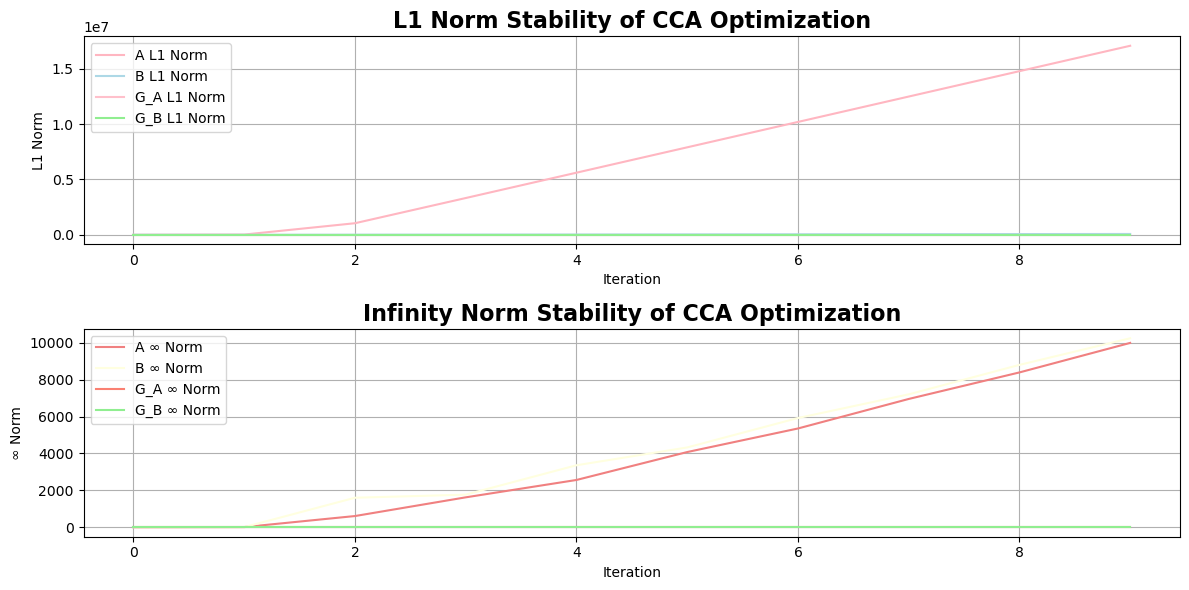

In [128]:
plt.figure(figsize=(12, 6))

# Plot L1 norms
plt.subplot(2, 1, 1)
plt.plot(data['Iteration'], data['A_l1'], color='lightpink', label='A L1 Norm')
plt.plot(data['Iteration'], data['B_l1'], color='lightblue', label='B L1 Norm')
plt.plot(data['Iteration'], data['G_A_l1'], color='pink', label='G_A L1 Norm')
plt.plot(data['Iteration'], data['G_B_l1'], color='lightgreen', label='G_B L1 Norm')
plt.title("L1 Norm Stability of CCA Optimization", fontsize=16, fontweight='bold')
plt.xlabel("Iteration")
plt.ylabel("L1 Norm")
plt.grid()
plt.legend()

# Plot L∞ norms
plt.subplot(2, 1, 2)
plt.plot(data['Iteration'], data['A_inf'], color='lightcoral', label='A ∞ Norm')
plt.plot(data['Iteration'], data['B_inf'], color='lightyellow', label='B ∞ Norm')
plt.plot(data['Iteration'], data['G_A_inf'], color='salmon', label='G_A ∞ Norm')
plt.plot(data['Iteration'], data['G_B_inf'], color='lightgreen', label='G_B ∞ Norm')
plt.title("Infinity Norm Stability of CCA Optimization", fontsize=16, fontweight='bold')
plt.xlabel("Iteration")
plt.ylabel("∞ Norm")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


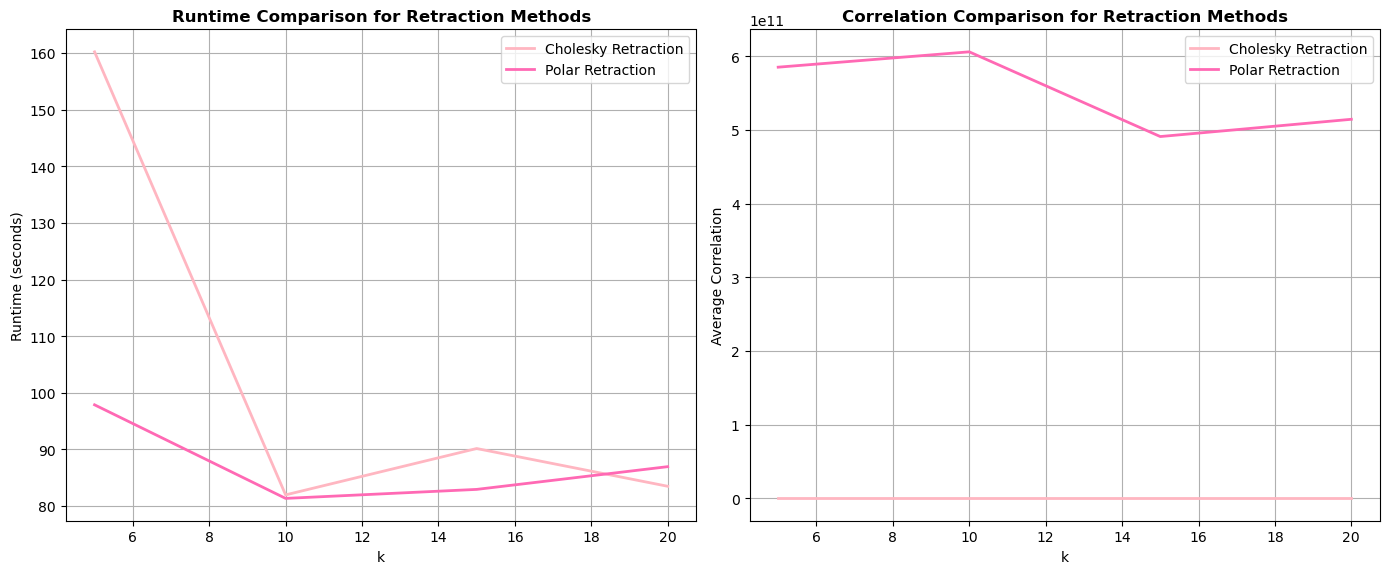

In [129]:
def plot_results(results):
    # Separate data for each method
    cholesky_results = results[results['method'] == 'cholesky']
    polar_results = results[results['method'] == 'polar']
    
    # Set up the figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot runtime comparison
    ax1.plot(cholesky_results['k'], cholesky_results['runtime'], label='Cholesky Retraction', color='lightpink', linewidth=2)
    ax1.plot(polar_results['k'], polar_results['runtime'], label='Polar Retraction', color='hotpink', linewidth=2)
    ax1.set_xlabel('k')
    ax1.set_ylabel('Runtime (seconds)')
    ax1.set_title('Runtime Comparison for Retraction Methods', fontweight='bold')
    ax1.grid(True)
    ax1.legend()

    # Plot correlation comparison
    ax2.plot(cholesky_results['k'], cholesky_results['correlations'].apply(np.mean), label='Cholesky Retraction', color='lightpink', linewidth=2)
    ax2.plot(polar_results['k'], polar_results['correlations'].apply(np.mean), label='Polar Retraction', color='hotpink', linewidth=2)
    ax2.set_xlabel('k')
    ax2.set_ylabel('Average Correlation')
    ax2.set_title('Correlation Comparison for Retraction Methods', fontweight='bold')
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_results(results)
